# MLP Model — Emission Point Classification (Aggregated Features)

This notebook develops a **Multilayer Perceptron (MLP)** model to classify particle emission points (`E1`, `E2`, `E3`) based on **aggregated features** extracted from sensor time series.  
The dataset `dataset_aggregated.csv` includes one row per simulation, with statistical summaries of sensor behavior and the corresponding emission class.

---

## 🎯 Objectives

- Load and preprocess the aggregated feature dataset  
- Normalize input features and encode the class labels  
- Apply stratified train/validation/test splitting  
- Design and train an MLP architecture suitable for tabular classification  
- Evaluate the model using accuracy, F1-score, and confusion matrix  
- Save the final trained model and performance summary

---

## 📁 Dataset Summary

- **Input**: Aggregated features derived from time-series windows  
- **Target**: Emission class (`E1`, `E2`, `E3`)  
- **Format**: CSV file where each row represents one simulation tag with numeric feature summaries

---

## ✅ Notebook Structure

0. Importing Librariues and Configuring GPU
1. Load and Inspect Aggregated Dataset  
2. Preprocess Features and Encode Target  
3. Stratified Train/Validation/Test Split  
4. Build and Train MLP Model  
5. Evaluate Model on Test Set  
6. Save Final Model and Results

---

> ⚠️ This notebook uses best practices for tabular classification and complements time-series models (e.g., CNN, LSTM) by leveraging descriptive statistics of sensor signals.


### 0. Importing Libraries and Configuring GPU

This block imports all the required libraries for data handling, preprocessing, evaluation, model building, and training. It includes tools for:

- Numerical and tabular data manipulation (`numpy`, `pandas`)
- Visualization (`matplotlib`, `seaborn`)
- Machine learning tools (`scikit-learn`)
- Deep learning with Keras and TensorFlow
- Progress tracking using `tqdm`
- Parameter grid creation with `product` from `itertools`

Additionally, the code checks if a GPU is available and configures TensorFlow to allocate GPU memory as needed. This ensures that training is accelerated on compatible hardware and avoids memory overload issues.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tqdm import tqdm
from itertools import product

# GPU config
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU detected! Device: ", gpus[0])
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("No GPU detected. Using CPU instead.")

GPU detected! Device:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### 1. Load and Inspect Aggregated Dataset

We begin by loading the aggregated dataset from CSV format.  
This dataset consists of one row per simulation or tag, where each row contains statistical summaries of sensor data along with the target emission class.

In this step, we:
- Preview the first few rows of the dataset  
- Examine the distribution of the target labels (`E1`, `E2`, `E3`)  
- Verify the dataset for missing values or irregularities


In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../data/processed/aggregated_dataset.csv')

# Basic overview
print("Dataset shape:", df.shape)
display(df.head())

# Check class distribution
print("\nClass distribution:")
display(df['classe'].value_counts())

# Check for missing values
print("\nMissing values:")
display(df.isnull().sum())


Dataset shape: (243, 10)


,0_mean,0_std,0_max,0_min,Direção do vento,Velocidade do vento (m/s),Intervalos de Emissão,Altura,classe,tag
0,200.245929,115.527415,400.0,0.46641,225,4.0,0.1,10,E1,1-A1
1,200.245795,115.527357,400.0,0.46641,225,4.0,0.1,15,E1,1-A2
2,200.246309,115.527184,400.0,0.46641,225,4.0,0.1,20,E1,1-A3
3,200.245764,115.527248,400.0,0.46641,225,4.0,0.2,10,E1,10-A1
4,200.245946,115.527384,400.0,0.46641,225,4.0,0.2,15,E1,10-A2



Class distribution:


classe
E1    81
E2    81
E3    81
Name: count, dtype: int64


Missing values:


0_mean                       0
0_std                        0
0_max                        0
0_min                        0
Direção do vento             0
Velocidade do vento (m/s)    0
Intervalos de Emissão        0
Altura                       0
classe                       0
tag                          0
dtype: int64

### 2. Preprocess Features and Encode Target

In this step, we prepare the data for training:

- Non-feature columns such as `'classe'` and (optionally) `'tag'` are removed from the input matrix.
- All numeric features are normalized using **StandardScaler** to ensure balanced gradient propagation during training.
- The target variable is encoded in two stages:
  - Categorical strings (E1, E2, E3) are converted to integer labels using `LabelEncoder`
  - Integer labels are transformed into one-hot vectors for softmax classification

These steps ensure the data is ready for model training using Keras.


In [5]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

# Drop non-numeric or identifier columns (adjust if needed)
X = df.drop(columns=['classe', 'tag'], errors='ignore')  # 'tag' might not exist
y_raw = df['classe'].values

# Normalize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode target: string → integer → one-hot
le = LabelEncoder()
y_int = le.fit_transform(y_raw)
y_cat = to_categorical(y_int)

# Confirm shapes
print("Features shape:", X_scaled.shape)
print("Labels shape (one-hot):", y_cat.shape)
print("Classes:", le.classes_)


Features shape: (243, 8)
Labels shape (one-hot): (243, 3)
Classes: ['E1' 'E2' 'E3']


### 3. Stratified Train/Validation/Test Split

To evaluate the model fairly, we split the dataset into three parts:

- **60% for training**
- **20% for validation**
- **20% for final testing (generalization)**

We use stratified sampling to preserve the distribution of emission classes across all subsets.  
This approach ensures that each class is proportionally represented, reducing the risk of training bias and ensuring robust model evaluation.


In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

# Step 1: reserve 20% for generalization test
X_remain, X_test, y_remain, y_test, y_int_remain, y_int_test = train_test_split(
    X_scaled, y_cat, y_int, test_size=0.2, random_state=42, stratify=y_int
)

# Step 2: split remaining 80% into 60% train and 20% val
X_train, X_val, y_train, y_val = train_test_split(
    X_remain, y_remain, test_size=0.25, random_state=42, stratify=y_int_remain
)

# Confirm shapes
print(f"Train set:      {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set:       {X_test.shape}, {y_test.shape}")

Train set:      (145, 8), (145, 3)
Validation set: (49, 8), (49, 3)
Test set:       (49, 8), (49, 3)


### 4. Build and Train MLP Model

We define and train a **Multilayer Perceptron (MLP)** for tabular classification.  
The architecture includes:

- Two hidden layers with ReLU activation and dropout (30%)  
- A final softmax output layer matching the number of emission classes  
- Categorical cross-entropy as the loss function  
- Early stopping based on validation loss to prevent overfitting

This architecture balances simplicity and performance, making it suitable for structured data.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define MLP architecture
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
5/5 [==============================] - 3s 62ms/step - loss: 1.1205 - accuracy: 0.2897 - val_loss: 1.1204 - val_accuracy: 0.1633
Epoch 2/100
5/5 [==============================] - 0s 12ms/step - loss: 1.1140 - accuracy: 0.3103 - val_loss: 1.1118 - val_accuracy: 0.1633
Epoch 3/100
5/5 [==============================] - 0s 11ms/step - loss: 1.0997 - accuracy: 0.3241 - val_loss: 1.1015 - val_accuracy: 0.2041
Epoch 4/100
5/5 [==============================] - 0s 11ms/step - loss: 1.0830 - accuracy: 0.4000 - val_loss: 1.0911 - val_accuracy: 0.2857
Epoch 5/100
5/5 [==============================] - 0s 10ms/step - loss: 1.0840 - accuracy: 0.3655 - val_loss: 1.0814 - val_accuracy: 0.3061
Epoch 6/100
5/5 [==============================] - 0s 10ms/step - loss: 1.0761 - accuracy: 0.3724 - val_loss: 1.0717 - val_accuracy: 0.2857
Epoch 7/100
5/5 [==============================] - 0s 11ms/step - loss: 1.0753 - accuracy: 0.4483 - val_loss: 1.0666 - val_accuracy: 0.3265
Epoch 8/100
5/5 [===

### 5. Evaluate MLP on Test Set

We evaluate the trained MLP model on the hold-out **test set**, which was not seen during training or validation.  
The following metrics are computed to assess performance:

- Accuracy and balanced accuracy  
- Macro-averaged precision, recall, and F1-score  
- Cohen’s Kappa (agreement beyond chance)

A **normalized confusion matrix** is also displayed to visualize how well each class is predicted.  
This step reveals the model’s real-world generalization ability.

2/2 [==============================] - 0s 2ms/step

Test Accuracy: 0.2857
Balanced Accuracy: 0.2806
Macro Precision: 0.3444
Macro Recall: 0.2806
Macro F1-Score: 0.2475
Cohen's Kappa: -0.0786

Classification Report:
              precision    recall  f1-score   support

          E1       0.50      0.06      0.11        16
          E2       0.20      0.25      0.22        16
          E3       0.33      0.53      0.41        17

    accuracy                           0.29        49
   macro avg       0.34      0.28      0.25        49
weighted avg       0.34      0.29      0.25        49



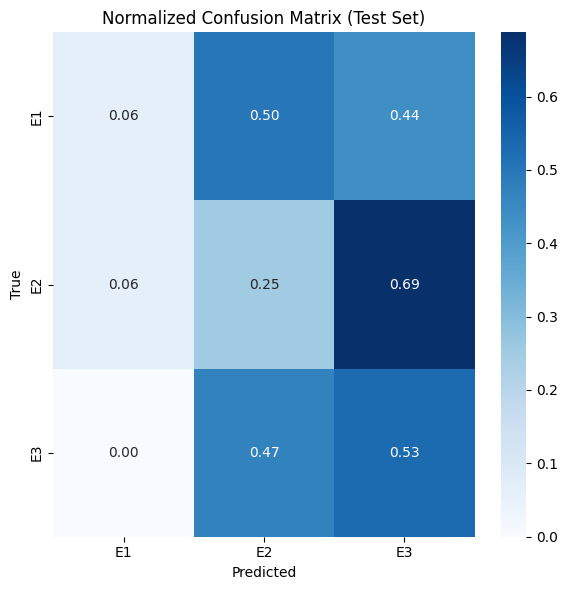

In [8]:
# 4. Evaluate MLP on Test Set

from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    cohen_kappa_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics
acc = accuracy_score(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)
macro_prec = precision_score(y_true, y_pred, average='macro')
macro_rec = recall_score(y_true, y_pred, average='macro')
macro_f1 = f1_score(y_true, y_pred, average='macro')
kappa = cohen_kappa_score(y_true, y_pred)

# Print results
print(f"\nTest Accuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"Macro Precision: {macro_prec:.4f}")
print(f"Macro Recall: {macro_rec:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Normalized Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


### 6. Save Final MLP Model and Summary

We save the trained MLP model to disk for future use or deployment.  
Additionally, we generate a structured summary containing:

- Evaluation metrics (accuracy, F1, etc.)
- Model architecture metadata
- Class label mapping

This step ensures that the model and its results can be reproduced or compared in future experiments.


In [9]:
# 5. Save Final MLP Model and Summary

import os
import json

# Summary dictionary
mlp_summary = {
    "Test Accuracy": round(acc, 4),
    "Balanced Accuracy": round(bal_acc, 4),
    "Macro Precision": round(macro_prec, 4),
    "Macro Recall": round(macro_rec, 4),
    "Macro F1-Score": round(macro_f1, 4),
    "Cohen's Kappa": round(kappa, 4),
    "Model Type": "MLP",
    "Input Shape": X_train.shape[1],
    "Classes": list(le.classes_)
}

# Save model
model.save("../models/mlp_model_aggregated_dataset.keras")

# Save summary
with open("../results/final_mlp_summary.json", "w") as f:
    json.dump(mlp_summary, f, indent=4)

print("✅ MLP model and summary saved to ./results/")


✅ MLP model and summary saved to ./results/
